In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h3
from geopy.distance import geodesic

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from matplotlib.ticker import MultipleLocator

## ToDo-Liste

- [ ] Verhältnis total miles und total price
  - [ ] Ausreißer rausschmeißen? Randfälle sind bei 100 000 schon 15 000
  - [ ] Möglichkeit Distanz und Zeit künstlich hinzufügen durch (Durchschnitt, Distanzberechnung) evaluieren
- [ ] Weitere Features hinzufügen
  - [ ] Distance to city centre
  - [ ] Fahrt zum Sportevent oder Fahrt zum Cafe
  - [ ] Distance to next café, POI point
- [ ] Welche spatial Information? Census-Tract Koordinaten, Community Area Daten, Centroid Daten und H3 mit Res 4, 6, 8
  - [ ] Census-Tract Koordinaten
  - [ ] Community Area Daten
  - [ ] Centroid Daten
  - [ ] H3 mit Res 4, 6, 8

## Data Loading, Checking, further Data Preparation and Cleaning

In [2]:
data = pd.read_csv("../data/analytics_trip_data.csv")

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# Korrekte Verwendung der describe-Methode
data.describe()

# Überprüfe auf NaN-Werte jeder Spalte
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          0
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                     0
trip_miles                       0
pickup_census_tract          37650
dropoff_census_tract         37650
pickup_community_area            2
dropoff_community_area          10
fare                             0
tips                             0
tolls                            0
extras                           0
trip_total                       0
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4                         0
h3_res_6                         0
h3_res_8                         0
h3_res_4_dropoff                 0
h3_res_6_dropoff                 0
h3_res_8_dropoff                 0
date                             0
temperature                      0
precipitation                    0
dtype: int64


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158868 entries, 0 to 158867
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    158868 non-null  object 
 1   taxi_id                    158868 non-null  object 
 2   trip_start_timestamp       158868 non-null  object 
 3   trip_end_timestamp         158868 non-null  object 
 4   trip_seconds               158868 non-null  float64
 5   trip_miles                 158868 non-null  float64
 6   pickup_census_tract        121218 non-null  float64
 7   dropoff_census_tract       121218 non-null  float64
 8   pickup_community_area      158866 non-null  float64
 9   dropoff_community_area     158858 non-null  float64
 10  fare                       158868 non-null  float64
 11  tips                       158868 non-null  float64
 12  tolls                      158868 non-null  float64
 13  extras                     15

In [5]:
data.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4,h3_res_6,h3_res_8,h3_res_4_dropoff,h3_res_6_dropoff,h3_res_8_dropoff,date,temperature,precipitation
0,0a0a2ca50df85134ce34f0c2c7bda6e78ca2a52c,bbe793119144e0bd97a4268af2a28ed0f3dad49545592ca9bc849b861760fd298cc9d873f749e3d8bad467cd77174ec6c05efa2b72af529b68ae7d01ff4c3fec,2018-01-01 00:15:00,2018-01-01 00:15:00,180.0,0.0,1.703108e+10,1.703132e+10,8.0,32.0,4.0,2.0,0.0,1.0,7.0,Credit Card,Blue Ribbon Taxi Association Inc.,POINT (-87.62621490639999 41.8925077809),POINT (-87.6209929134 41.8849871918),862664c1fffffff,842664dffffffff,882664c1e1fffff,842664dffffffff,862664c1fffffff,882664c1e3fffff,2018-01-01 01:53:00,-18.333333,0.0


In [6]:
#Hier erstmal date genommen, vielleicht doch lieber startzeit?
data['date_column'] = pd.to_datetime(data['date'])
data['hour']= data["date_column"].dt.hour
data['weekday']=data["date_column"].dt.weekday
data["month"]=data["date_column"].dt.month

data = data[(data['trip_seconds'] != 0) & (data['trip_miles'] != 0) & (data['trip_total'] != 0)]

data['price_per_mile'] = data.apply(lambda row: row['trip_total'] / row['trip_miles'] if row['trip_miles'] != 0 and row['trip_total'] != 0 else np.nan, axis=1)

In [7]:
# Koordinaten des Stadtzentrums von Chicago
#chicago_coords = (41.8781, -87.6298)
#chicago_h3 = h3.geo_to_h3(chicago_coords[0], chicago_coords[1], 8)
#data['distance_to_chicago'] = data['h3_res_8'].apply(lambda h3_index: h3.h3_distance(chicago_h3, h3_index))

In [8]:
# Koordinaten des Stadtzentrums von Chicago
chicago_coords = (41.8781, -87.6298)

# Funktion zum Extrahieren der Koordinaten aus dem WKT-Format
def extract_coords(point):
    point = point.replace('POINT (', '').replace(')', '')
    lon, lat = map(float, point.split())
    return lat, lon

# Funktion zur Berechnung der Distanz
def calculate_distance_to_chicago(point):
    point_coords = extract_coords(point)
    return geodesic(point_coords, chicago_coords).miles

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_to_chicago'] = data['pickup_centroid_location'].apply(calculate_distance_to_chicago)

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_from_chicago'] = data['dropoff_centroid_location'].apply(calculate_distance_to_chicago)


## Feature Creating & Selection

In [9]:
#features = ["trip_id", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "trip_seconds", "trip_miles", "pickup_census_tract", "dropoff_census_tract", "pickup_community_area", "dropoff_community_area", "fare", "tips", "tolls", "extras", "trip_total", "payment_type", "company", "pickup_centroid_latitude", "pickup_centroid_longitude", "pickup_centroid_location", "dropoff_centroid_latitude", "dropoff_centroid_longitude", "dropoff_centroid_location"]
features = ["trip_seconds", "trip_miles", "fare", "trip_total", "hour", "weekday", "month","precipitation","temperature","price_per_mile", "distance_to_chicago", "distance_from_chicago"]

In [10]:
Cluster_all = data[features]

In [11]:
Cluster_all.describe()

,trip_seconds,trip_miles,fare,trip_total,hour,weekday,month,precipitation,temperature,price_per_mile,distance_to_chicago,distance_from_chicago
count,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.0,135793.0,135793.000000,135793.000000,135793.000000,135793.000000
mean,485.742461,1.500303,7.757121,9.106324,12.738300,2.821073,1.0,0.0,-13.580364,10.740603,1.533225,1.793731
std,261.932651,1.164260,3.006274,3.493272,5.863521,1.707156,0.0,0.0,3.921343,19.449632,1.785812,1.868943
min,1.000000,0.010000,0.010000,0.250000,0.000000,0.000000,1.0,0.0,-22.777778,0.089286,0.243471,0.243471
25%,300.000000,0.700000,5.500000,6.500000,9.000000,1.000000,1.0,0.0,-16.111111,5.129032,0.657472,0.667513
50%,420.000000,1.120000,7.000000,8.500000,13.000000,3.000000,1.0,0.0,-13.333333,6.887755,1.011416,1.122737
75%,624.000000,1.900000,9.000000,10.750000,17.000000,4.000000,1.0,0.0,-10.555556,9.500000,1.494985,2.036920
max,1500.000000,5.850000,20.500000,24.000000,23.000000,6.000000,1.0,0.0,-1.666667,950.000000,16.238510,16.238510


In [12]:
# Bestimmte Spalten auswählen
columns_of_interest = ['trip_seconds', 'trip_miles', 'trip_total']

# Anzahl der Nullwerte in den ausgewählten Spalten
zero_counts_selected_columns = (Cluster_all[columns_of_interest] == 0).sum()
print("Anzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:")
print(zero_counts_selected_columns)

# Gesamtzahl der Nullwerte in den ausgewählten Spalten
total_zeros_selected_columns = (Cluster_all[columns_of_interest] == 0).sum().sum()
print("\nGesamtzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:")
print(total_zeros_selected_columns)

Anzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:
trip_seconds    0
trip_miles      0
trip_total      0
dtype: int64

Gesamtzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:
0


In [13]:
Cluster_all.info()
print(len(Cluster_all))
print(Cluster_all['price_per_mile'].isna().sum())
Cluster_all.dropna(inplace=True)
print(len(Cluster_all))
Cluster_all.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 135793 entries, 1 to 158867
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_seconds           135793 non-null  float64
 1   trip_miles             135793 non-null  float64
 2   fare                   135793 non-null  float64
 3   trip_total             135793 non-null  float64
 4   hour                   135793 non-null  int32  
 5   weekday                135793 non-null  int32  
 6   month                  135793 non-null  int32  
 7   precipitation          135793 non-null  float64
 8   temperature            135793 non-null  float64
 9   price_per_mile         135793 non-null  float64
 10  distance_to_chicago    135793 non-null  float64
 11  distance_from_chicago  135793 non-null  float64
dtypes: float64(9), int32(3)
memory usage: 11.9 MB
135793
0
135793


C:\Users\kevin\AppData\Local\Temp\ipykernel_3296\8445324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_all.dropna(inplace=True)


,trip_seconds,trip_miles,fare,trip_total,hour,weekday,month,precipitation,temperature,price_per_mile,distance_to_chicago,distance_from_chicago
count,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.0,135793.0,135793.000000,135793.000000,135793.000000,135793.000000
mean,485.742461,1.500303,7.757121,9.106324,12.738300,2.821073,1.0,0.0,-13.580364,10.740603,1.533225,1.793731
std,261.932651,1.164260,3.006274,3.493272,5.863521,1.707156,0.0,0.0,3.921343,19.449632,1.785812,1.868943
min,1.000000,0.010000,0.010000,0.250000,0.000000,0.000000,1.0,0.0,-22.777778,0.089286,0.243471,0.243471
25%,300.000000,0.700000,5.500000,6.500000,9.000000,1.000000,1.0,0.0,-16.111111,5.129032,0.657472,0.667513
50%,420.000000,1.120000,7.000000,8.500000,13.000000,3.000000,1.0,0.0,-13.333333,6.887755,1.011416,1.122737
75%,624.000000,1.900000,9.000000,10.750000,17.000000,4.000000,1.0,0.0,-10.555556,9.500000,1.494985,2.036920
max,1500.000000,5.850000,20.500000,24.000000,23.000000,6.000000,1.0,0.0,-1.666667,950.000000,16.238510,16.238510


In [14]:
#Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"])
def one_hot_encoding(df, list):
    for element in list:
        one_hot_encoded = pd.get_dummies(df[element], prefix=element)

        one_hot_encoded = one_hot_encoded.astype(int)
        
        # Concatenate the one-hot encoded features with the original DataFrame
        df = pd.concat([df, one_hot_encoded], axis=1)

        # Drop the original column after one-hot encoding
        df = df.drop(columns=[element])
    return  df

Cluster_all_ohe = one_hot_encoding(Cluster_all, ["hour", "weekday", "month"])


In [15]:
Cluster_all_ohe.head(1)

,trip_seconds,trip_miles,fare,trip_total,precipitation,temperature,price_per_mile,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1
1,217.0,0.61,4.75,6.25,0.0,-18.333333,10.245902,0.251003,0.657472,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [16]:
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'trip_miles', 'fare', 'trip_total', 'precipitation',
       'temperature', 'price_per_mile', 'distance_to_chicago',
       'distance_from_chicago', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'month_1'],
      dtype='object')


## Data Normalisation/Scaling

In [17]:
columns_to_normalize=["trip_seconds", "fare", "trip_miles", "trip_total", "precipitation", "temperature","price_per_mile","distance_to_chicago", "distance_from_chicago"]
#columns_to_normalize=['connectionDuration', 'chargingDuration', 'kWhDelivered', 'kWhRequested', 'precipitation', 'temperature', 'minutesAvailable']

In [18]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'trip_miles', 'fare', 'trip_total', 'precipitation',
       'temperature', 'price_per_mile', 'distance_to_chicago',
       'distance_from_chicago', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'month_1'],
      dtype='object')


In [19]:
Cluster_all_ohe.describe()

,trip_seconds,trip_miles,fare,trip_total,precipitation,temperature,price_per_mile,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1
count,135793.000000,135793.000000,135793.000000,135793.000000,135793.0,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.000000,135793.0
mean,0.323377,0.255189,0.378093,0.372898,0.0,0.435667,0.011213,0.080635,0.096921,0.016849,0.049156,0.024199,0.018896,0.008137,0.007239,0.017041,0.040753,0.051137,0.052020,0.045039,0.057131,0.057978,0.055658,0.055386,0.065033,0.077854,0.075048,0.061594,0.051262,0.034567,0.030929,0.026658,0.020436,0.112701,0.145486,0.164176,0.193626,0.209193,0.119321,0.055496,1.0
std,0.174738,0.199360,0.146719,0.147085,0.0,0.185748,0.020475,0.111648,0.116845,0.128707,0.216194,0.153666,0.136160,0.089840,0.084774,0.129423,0.197719,0.220277,0.222069,0.207391,0.232094,0.233703,0.229261,0.228733,0.246585,0.267942,0.263470,0.240417,0.220532,0.182682,0.173127,0.161083,0.141485,0.316228,0.352592,0.370437,0.395140,0.406734,0.324167,0.228947,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.199466,0.118151,0.267936,0.263158,0.0,0.315789,0.005305,0.025883,0.026511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.279520,0.190068,0.341142,0.347368,0.0,0.447368,0.007157,0.048011,0.054971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.415610,0.323630,0.438751,0.442105,0.0,0.578947,0.009907,0.078244,0.112125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


## PCA

(135793, 41)
the total variancein our dataset is 1.963622012941948
the 95% of the variance in our dataset is 1.8654409122948505


Text(0, 0.5, '% explained_variance_ratio')

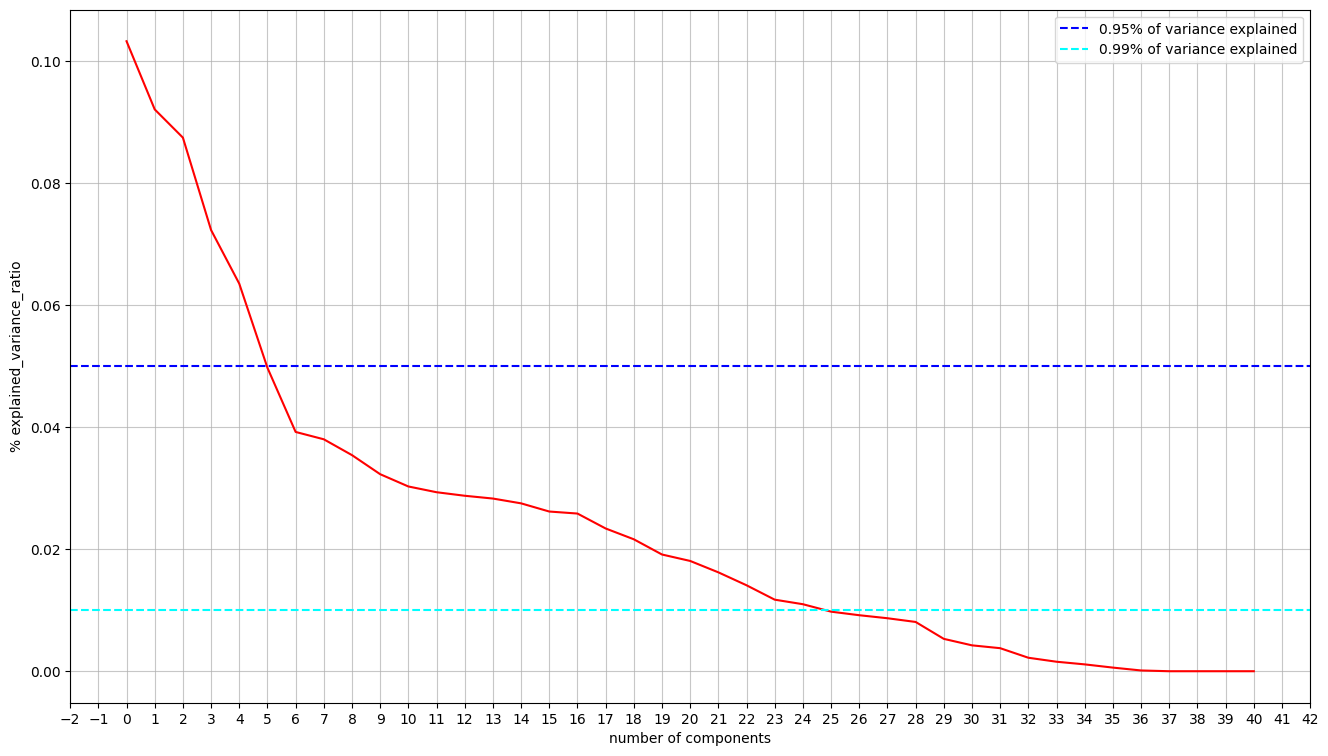

In [20]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

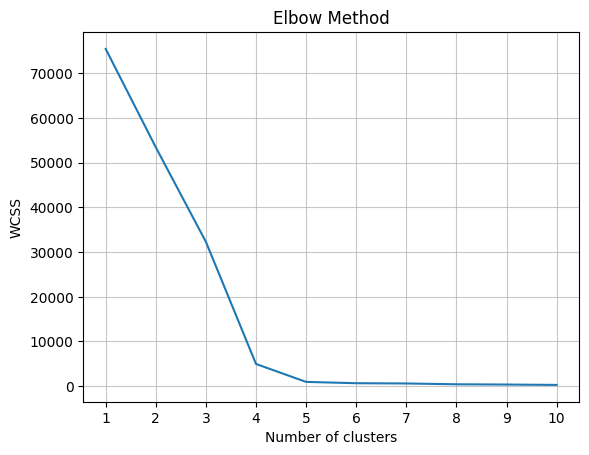

In [21]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

## Clustering (Hard)

In [22]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=4, random_state=42)

In [23]:
labels = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score = silhouette_score(X_pca, labels)
print(f"Silhouette Score for 4 clusters: {silhouette_score}")

Silhouette Score for 4 clusters: 0.8293517935206575


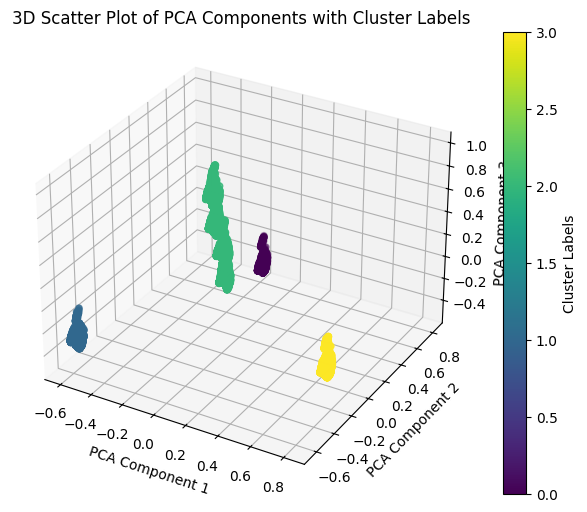

In [24]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [25]:
Cluster_all["clusters"]= labels

C:\Users\kevin\AppData\Local\Temp\ipykernel_3296\2568049963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_all["clusters"]= labels


In [26]:
X_pca.shape

(135793, 3)

## Clustering (Soft)

In [27]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_pca)
labels = gmm.predict(X_pca)

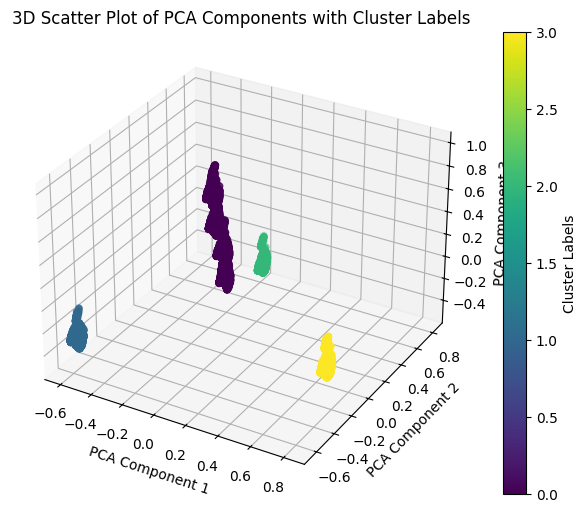

In [28]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [29]:
probs = gmm.predict_proba(X_pca)
print(probs[:5].round(3))
print(X_pca)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[-0.06252083  0.03654997  0.62139691]
 [-0.05414675  0.05253577  0.68931742]
 [-0.06199474  0.04049541  0.63710134]
 ...
 [-0.05844547  0.17801528 -0.14579669]
 [-0.05526806  0.17758625 -0.14614028]
 [-0.06195265  0.17928783 -0.14325486]]


<class 'numpy.ndarray'>
(135793, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135793 entries, 0 to 135792
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   0        135793 non-null  float64
 1   1        135793 non-null  float64
 2   2        135793 non-null  float64
 3   Cluster  135793 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 4.1 MB


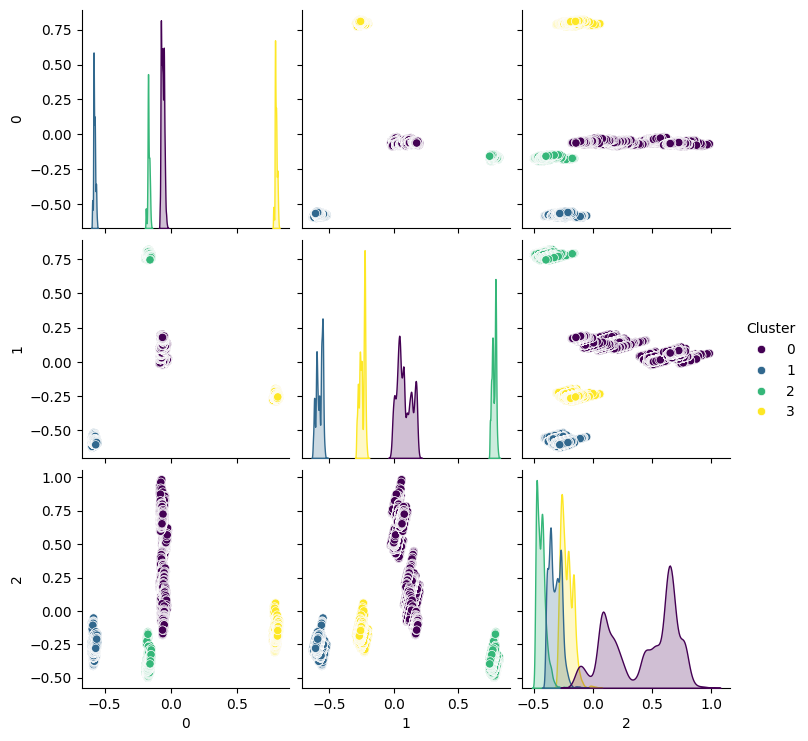

In [30]:
print(type(X_pca))
print(X_pca.shape)
X_pca_df = pd.DataFrame(X_pca)
X_pca_df['Cluster'] = labels
X_pca_df.info()
X_pca_df.describe()
sns.pairplot(X_pca_df, hue='Cluster', palette='viridis')
plt.show()

## Spatial Kernel Density Estimation

## Visualisation and Interpretation